# Load packages

In [ ]:
import shutil
import os
import pandas as pd
import matplotlib.pyplot as plt

!pip install resemblyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.8 MB/s eta 0:00:00


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
from resemblyzer import sampling_rate
from matplotlib import cm
from time import sleep, perf_counter as timer
from umap import UMAP
from sys import stderr
import matplotlib.pyplot as plt
import numpy as np

_default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
_my_colors = np.array([
    [0, 127, 70],
    [255, 0, 0],
    [255, 217, 38],
    [0, 135, 255],
    [165, 0, 165],
    [255, 167, 255],
    [97, 142, 151],
    [0, 255, 255],
    [255, 96, 38],
    [142, 76, 0],
    [33, 0, 127],
    [0, 0, 0],
    [183, 183, 183],
    [76, 255, 0],
    [89, 32, 12],
    [12, 200, 150],
    [250, 100, 50],
    [23, 34, 100],
], dtype=float) / 255


def play_wav(wav, blocking=True):
    try:
        import sounddevice as sd
        # Small bug with sounddevice.play: the audio is cut 0.5 second too early. We pad it to
        # make up for that
        wav = np.concatenate((wav, np.zeros(sampling_rate // 2)))
        sd.play(wav, sampling_rate, blocking=blocking)
    except Exception as e:
        print("Failed to play audio: %s" % repr(e))


def plot_similarity_matrix(matrix, labels_a=None, labels_b=None, ax: plt.Axes=None, title=""):
    if ax is None:
        _, ax = plt.subplots()
    fig = plt.gcf()

    img = ax.matshow(matrix, extent=(-0.5, matrix.shape[0] - 0.5,
                                     -0.5, matrix.shape[1] - 0.5))

    ax.xaxis.set_ticks_position("bottom")
    if labels_a is not None:
        ax.set_xticks(range(len(labels_a)))
        ax.set_xticklabels(labels_a, rotation=90)
    if labels_b is not None:
        ax.set_yticks(range(len(labels_b)))
        ax.set_yticklabels(labels_b[::-1])  # Upper origin -> reverse y axis
    ax.set_title(title)

    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.15)
    fig.colorbar(img, cax=cax, ticks=np.linspace(0.4, 1, 7))
    img.set_clim(0.4, 1)
    img.set_cmap("inferno")

    return ax


def plot_histograms(all_samples, ax=None, names=None, title=""):
    """
    Plots (possibly) overlapping histograms and their median
    """
    if ax is None:
        _, ax = plt.subplots()

    for samples, color, name in zip(all_samples, _default_colors, names):
        ax.hist(samples + np.random.normal(0, 0.05, len(samples)), density=True, color=color + "80", label=name)
    ax.legend()
    ax.set_xlim(0.35, 1)
    # ax.set_yticks([])
    ax.set_title(title)

    ylim = ax.get_ylim()
    ax.set_ylim(*ylim)      # Yeah, I know
    for samples, color in zip(all_samples, _default_colors):
        median = np.median(samples)
        ax.vlines(median, *ylim, color, "dashed")
        ax.text(median, ylim[1] * 0.15, "median", rotation=270, color=color)

    return ax


# def plot_projections(embeds, speakers, ax=None, colors=None, markers=None, legend=True,
#                      title="", **kwargs):
#     if ax is None:
#         _, ax = plt.subplots(figsize=(6, 6))

#     # Compute the 2D projections. You could also project to another number of dimensions (e.g.
#     # for a 3D plot) or use a different different dimensionality reduction like PCA or TSNE.
#     reducer = UMAP(**kwargs)
#     projs = reducer.fit_transform(embeds)

#     # Draw the projections
#     speakers = np.array(speakers)
#     colors = colors or _my_colors
#     for i, speaker in enumerate(np.unique(speakers)):
#         speaker_projs = projs[speakers == speaker]
#         marker = "o" if markers is None else markers[i]
#         label = speaker if legend else None

#         ax.scatter(*speaker_projs.T, c=[colors[i]], marker=marker, label=label)

#     if legend:
#         ax.legend(title="Speakers", ncol=2)
#     ax.set_title(title)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_aspect("equal")

#     return projs


def plot_projections(embeds, speakers, ax=None, colors=None, markers=None, legend=True,
                     title="", **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    # Compute the 2D projections. You could also project to another number of dimensions (e.g.
    # for a 3D plot) or use a different different dimensionality reduction like PCA or TSNE.
    reducer = UMAP(**kwargs)
    projs = reducer.fit_transform(embeds)

    # Add noise to each point
    noise_level = 0.5
    projs = projs + np.random.normal(0, noise_level, size=projs.shape)

    # Draw the projections
    speakers = np.array(speakers)
    markers = np.array(markers)
    colors = colors or _my_colors

    for i, speaker in enumerate(np.unique(speakers)):
        speaker_projs = projs[speakers == speaker]
        # marker = "o" if markers is None else markers[i]
        marker = markers[speakers == speaker][0]
        label = speaker if legend else None

        # ax.scatter(*speaker_projs.T, c=[colors[i]], marker=marker, label=label)
        plt.scatter(*speaker_projs.T, c=[colors[i]], marker=marker, label=label, alpha=0.7)

    if legend:
        ax.legend(title="Speakers", ncol=2)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")

    return projs



def interactive_diarization(similarity_dict, wav, wav_splits, x_crop=5, show_time=False):
    fig, ax = plt.subplots()
    lines = [ax.plot([], [], label=name)[0] for name in similarity_dict.keys()]
    text = ax.text(0, 0, "", fontsize=10)

    def init():
        ax.set_ylim(0.4, 1)
        ax.set_ylabel("Similarity")
        if show_time:
            ax.set_xlabel("Time (seconds)")
        else:
            ax.set_xticks([])
        ax.set_title("Diarization")
        ax.legend(loc="lower right")
        return lines + [text]

    times = [((s.start + s.stop) / 2) / sampling_rate for s in wav_splits]
    rate = 1 / (times[1] - times[0])
    crop_range = int(np.round(x_crop * rate))
    ticks = np.arange(0, len(wav_splits), rate)
    ref_time = timer()

    def update(i):
        # Crop plot
        crop = (max(i - crop_range // 2, 0), i + crop_range // 2)
        ax.set_xlim(i - crop_range // 2, crop[1])
        if show_time:
            crop_ticks = ticks[(crop[0] <= ticks) * (ticks <= crop[1])]
            ax.set_xticks(crop_ticks)
            ax.set_xticklabels(np.round(crop_ticks / rate).astype(np.int))

        # Plot the prediction
        similarities = [s[i] for s in similarity_dict.values()]
        best = np.argmax(similarities)
        name, similarity = list(similarity_dict.keys())[best], similarities[best]
        if similarity > 0.75:
            message = "Speaker: %s (confident)" % name
            color = _default_colors[best]
        elif similarity > 0.65:
            message = "Speaker: %s (uncertain)" % name
            color = _default_colors[best]
        else:
            message = "Unknown/No speaker"
            color = "black"
        text.set_text(message)
        text.set_c(color)
        text.set_position((i, 0.96))

        # Plot data
        for line, (name, similarities) in zip(lines, similarity_dict.items()):
            line.set_data(range(crop[0], i + 1), similarities[crop[0]:i + 1])

        # Block to synchronize with the audio (interval is not reliable)
        current_time = timer() - ref_time
        if current_time < times[i]:
            sleep(times[i] - current_time)
        elif current_time - 0.2 > times[i]:
            print("Animation is delayed further than 200ms!", file=stderr)
        return lines + [text]

    ani = FuncAnimation(fig, update, frames=len(wav_splits), init_func=init, blit=not show_time,
                        repeat=False, interval=1)
    play_wav(wav, blocking=False)
    plt.show()


def plot_embedding_as_heatmap(embed, ax=None, title="", shape=None, color_range=(0, 0.30)):
    if ax is None:
        _, ax = plt.subplots()

    if shape is None:
        height = int(np.sqrt(len(embed)))
        shape = (height, -1)
    embed = embed.reshape(shape)

    cmap = cm.get_cmap()
    mappable = ax.imshow(embed, cmap=cmap)
    cbar = plt.colorbar(mappable, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_clim(*color_range)

    ax.set_xticks([]), ax.set_yticks([])
    ax.set_title(title)

# Load data
* Subir audio.zip y synthesized_audios.zip

In [ ]:
import zipfile
import os
import shutil
import glob
import pandas as pd

def unzip_files(zip_file_path):

  destination_folder = zip_file_path.split('.zip')[0]

  # Create the destination folder if it doesn't exist
  if not os.path.exists(destination_folder):
      os.makedirs(destination_folder)

  # Open the zip file
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      # Extract all contents to the destination folder
      zip_ref.extractall(destination_folder)

  print(f"Contents of '{zip_file_path}' extracted to '{destination_folder}'.")

In [ ]:
unzip_files('audio.zip')
unzip_files('synthesized_audios.zip')
shutil.rmtree('sample_data')
os.remove('audio.zip')
os.remove('synthesized_audios.zip')

Contents of 'audio.zip' extracted to 'audio'.
Contents of 'synthesized_audios.zip' extracted to 'synthesized_audios'.


In [ ]:
import os
import shutil

# Define the paths
outer_folder = 'synthesized_audios'
inner_folder = os.path.join(outer_folder, outer_folder)

# Move the contents of the inner folder to the outer folder
for item in os.listdir(inner_folder):
    source_path = os.path.join(inner_folder, item)
    destination_path = os.path.join(outer_folder, item)
    shutil.move(source_path, destination_path)

# Remove the inner folder
shutil.rmtree(inner_folder)

print("Folders rearranged successfully.")


Folders rearranged successfully.


In [ ]:
import random
import IPython
from IPython.display import Audio

reference_audios_path = 'audio/Spanish'
directory_name = 'synthesized_audios/XTTS/Spanish'

def compare_real_vs_synthesized_voices(metadata_model_df):

  index = random.choice(metadata_model_df.index)
  reference_audio_id = metadata_model_df.loc[index, 'Reference audio ID']
  reference_audio = os.path.join(reference_audios_path, reference_audio_id +'.wav')
  print('\n Reference audio:')
  IPython.display.display(Audio(reference_audio))

  synthesized_audio_id = metadata_model_df.loc[index, 'Synthesized audio ID']
  synthesized_audio = os.path.join(directory_name, synthesized_audio_id +'.wav')
  print('\n Synthesized speech:')
  IPython.display.display(Audio(synthesized_audio))

In [ ]:
compare_real_vs_synthesized_voices(pd.read_csv('synthesized_audios/XTTS/Spanish_XTTS_metadata.csv'))


 Reference audio:



 Synthesized speech:


# Demo 1: Cross-similarity

## Prepare the data as necessary

In [ ]:
import wave
import time
def get_audio_length(file_path):
    with wave.open(file_path, 'rb') as audio_file:
        # Get the number of frames and the frame rate
        num_frames = audio_file.getnframes()
        frame_rate = audio_file.getframerate()

        # Calculate the duration in seconds
        duration = num_frames / frame_rate

    return duration

In [ ]:
# def prepare_audios(original_directory, new_directory, min_duration=0):

#   # Create the new directory if it doesn't exist
#   if not os.path.exists(new_directory):
#       os.makedirs(new_directory)

#   # Iterate through files in the original directory
#   for filename in os.listdir(original_directory):

#       if filename.endswith('.wav'):
#         original_file_path = os.path.join(original_directory, filename)

#         if get_audio_length(original_file_path) > min_duration:
#           # Extract speaker information from the filename
#           speaker = filename.split('_')[0]

#           # Create speaker directory in the new directory if it doesn't exist
#           speaker_directory = os.path.join(new_directory, speaker)
#           if not os.path.exists(speaker_directory):
#               os.makedirs(speaker_directory)

#           # Copy the file to the corresponding speaker directory in the new directory
#           new_file_path = os.path.join(speaker_directory, filename)
#           shutil.copy(original_file_path, new_file_path)


In [ ]:
def prepare_audios(original_directory, new_directory):

  # Create the new directory if it doesn't exist
  os.makedirs(new_directory)

  wav_files = glob.glob(os.path.join(original_directory, '**/*.wav'), recursive=True)

  for wav_file in wav_files:

    filename = wav_file.split('/')[-1]
    speaker_id = filename.split('_')[0]

    speaker_directory = os.path.join(new_directory, speaker_id)
    if not os.path.exists(speaker_directory):
      os.makedirs(speaker_directory)


    new_file_path = os.path.join(speaker_directory, filename)
    shutil.copy(wav_file, new_file_path)


## Run demo

In [ ]:
from resemblyzer import preprocess_wav, VoiceEncoder
# from demo_utils import *
from itertools import groupby
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

def demo1(audios_path):

  # DEMO 01: we'll show how to compare speech segments (=utterances) between them to get a metric
  # on how similar their voices sound. We expect utterances from the same speaker to have a high
  # similarity, and those from distinct speakers to have a lower one.


  # The neural network will automatically use CUDA if it'speaker available on your machine, otherwise it
  # will use the CPU. You can enforce a device of your choice by passing its name as argument to the
  # constructor. The model might take a few seconds to load with CUDA, but it then executes very
  # quickly.
  encoder = VoiceEncoder()

  # N.B. "wav" in variable names stands
  # for "waveform" and not the wav file extension.
  wav_fpaths = list(Path(audios_path).glob("**/*.wav"))
  wav_fpaths

  # Group the wavs per speaker and load them using the preprocessing function provided with
  # resemblyzer to load wavs in memory. It normalizes the volume, trims long silences and resamples
  # the wav to the correct sampling rate.
  speaker_wavs = {speaker: list(map(preprocess_wav, wav_fpaths)) for speaker, wav_fpaths in
                  groupby(tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), unit="wavs"),
                          lambda wav_fpath: wav_fpath.parent.stem)}

  ## Similarity between two utterances from each speaker
  # Embed two utterances A and B for each speaker
  embeds_a = np.array([encoder.embed_utterance(wavs[0]) for wavs in speaker_wavs.values()])
  embeds_b = np.array([encoder.embed_utterance(wavs[1]) for wavs in speaker_wavs.values()])
  # Each array is of shape (num_speakers, embed_size)
  print("Shape of embeddings: %s" % str(embeds_a.shape))

  # Compute the similarity matrix. The similarity of two embeddings is simply their dot
  # product, because the similarity metric is the cosine similarity and the embeddings are
  # already L2-normed.
  # Short version:
  utt_sim_matrix = np.inner(embeds_a, embeds_b)
  # Long, detailed version:
  utt_sim_matrix2 = np.zeros((len(embeds_a), len(embeds_b)))
  for i in range(len(embeds_a)):
      for j in range(len(embeds_b)):
          # The @ notation is exactly equivalent to np.dot(embeds_a[i], embeds_b[i])
          utt_sim_matrix2[i, j] = embeds_a[i] @ embeds_b[j]
  assert np.allclose(utt_sim_matrix, utt_sim_matrix2)


  ## Similarity between two speaker embeddings
  # Divide the utterances of each speaker in groups of identical size and embed each group as a
  # speaker embedding
  spk_embeds_a = np.array([encoder.embed_speaker(wavs[:len(wavs) // 2]) \
                          for wavs in speaker_wavs.values()])
  spk_embeds_b = np.array([encoder.embed_speaker(wavs[len(wavs) // 2:]) \
                          for wavs in speaker_wavs.values()])
  spk_sim_matrix = np.inner(spk_embeds_a, spk_embeds_b)


  ## Draw the plots
  fix, axs = plt.subplots(1, 2, figsize=(8, 4))
  labels_a = ["%s-A" % i for i in speaker_wavs.keys()]
  labels_b = ["%s-B" % i for i in speaker_wavs.keys()]
  mask = np.eye(len(utt_sim_matrix), dtype=bool)
  # plot_similarity_matrix(utt_sim_matrix, labels_a, labels_b, axs[0, 0],
  #                       "Cross-similarity between utterances\n(speaker_id-utterance_group)")
  # plot_histograms((utt_sim_matrix[mask], utt_sim_matrix[np.logical_not(mask)]), axs[0, 1],
  #                 ["Same speaker", "Different speakers"],
  #                 "Normalized histogram of similarity\nvalues between utterances")
  plot_similarity_matrix(spk_sim_matrix, labels_a, labels_b, axs[0],)
                        # "Cross-similarity between speakers")
  plot_histograms((spk_sim_matrix[mask], spk_sim_matrix[np.logical_not(mask)]), axs[1],
                  ["Same speaker", "Different speakers"],)
                  # "Normalized histogram of similarity\nvalues between speakers")
  plt.show()

In [ ]:
# shutil.rmtree('_demo')





_demo
Loaded the voice encoder model on cpu in 0.05 seconds.


Preprocessing wavs: 100%|██████████| 377/377 [00:31<00:00, 11.81wavs/s]


Shape of embeddings: (18, 256)


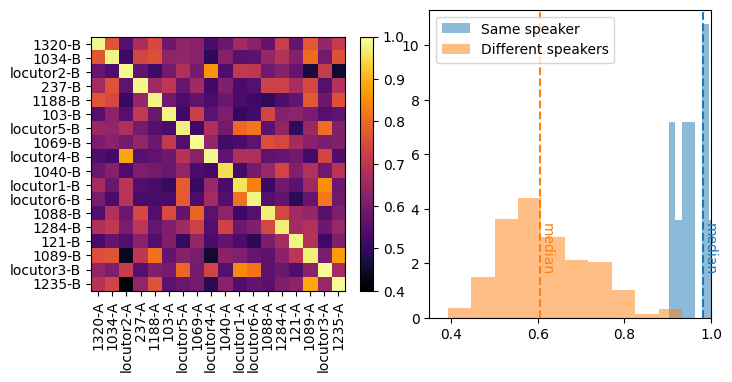





YourTTS_demo
Loaded the voice encoder model on cpu in 0.01 seconds.


Preprocessing wavs: 100%|██████████| 377/377 [00:05<00:00, 66.94wavs/s]


Shape of embeddings: (18, 256)


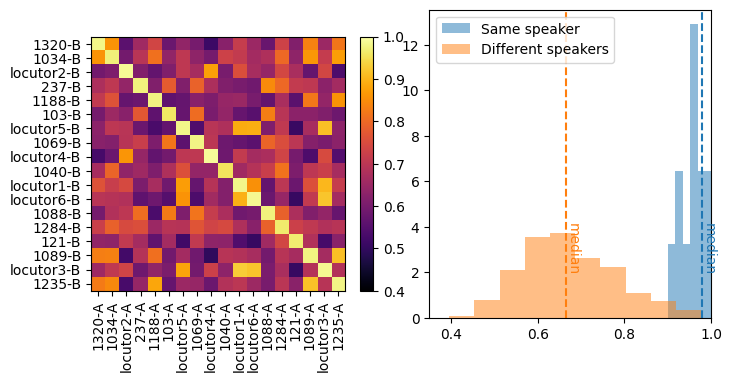





XTTS_demo
Loaded the voice encoder model on cpu in 0.01 seconds.


Preprocessing wavs: 100%|██████████| 377/377 [00:07<00:00, 53.39wavs/s]


Shape of embeddings: (18, 256)


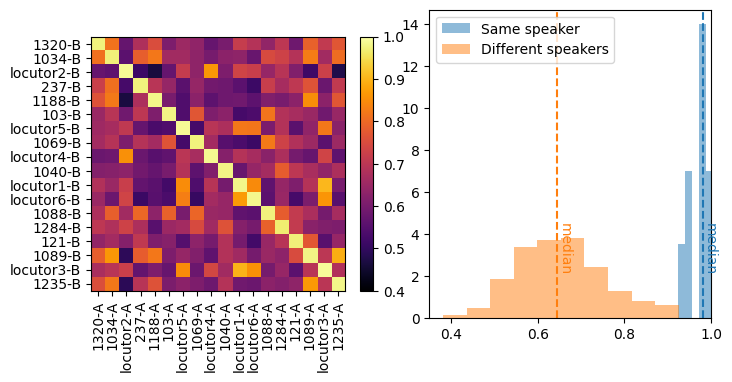





TorToise_demo
Loaded the voice encoder model on cpu in 0.01 seconds.


Preprocessing wavs: 100%|██████████| 240/240 [00:03<00:00, 73.45wavs/s]


Shape of embeddings: (12, 256)


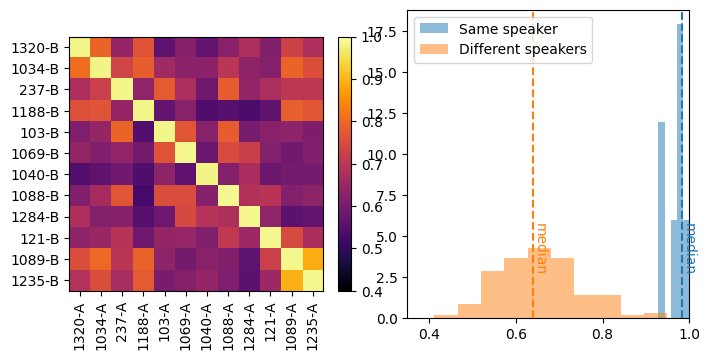

In [ ]:
original_directories = ['audio', 'synthesized_audios/YourTTS', 'synthesized_audios/XTTS', 'synthesized_audios/TorToise']

for original_directory in original_directories:
    new_directory = '/'.join(original_directory.split('/')[1:]) + '_demo'
    prepare_audios(original_directory, new_directory)
    print('\n\n\n')
    print(new_directory)
    demo1(new_directory)
    shutil.rmtree(new_directory)

In [ ]:
# original_directories = ['audio/Spanish', 'audio/train', 'audio/test',
#                         'synthesized_audios/YourTTS/Spanish', 'synthesized_audios/YourTTS/train', 'synthesized_audios/YourTTS/test',
#                         'synthesized_audios/XTTS/Spanish', 'synthesized_audios/XTTS/train', 'synthesized_audios/XTTS/test',
#                         'synthesized_audios/TorToise/Spanish', 'synthesized_audios/TorToise/train', 'synthesized_audios/TorToise/test']

# for original_directory in original_directories:
#   try:
#     new_directory = '/'.join(original_directory.split('/')[1:]) + '_demo'
#     prepare_audios(original_directory, new_directory, min_duration=0)
#     print('\n\n\n')
#     print(new_directory)
#     demo1(new_directory)
#     shutil.rmtree(new_directory)
#   except:
#     pass

# shutil.rmtree('XTTS')
# shutil.rmtree('YourTTS')
# shutil.rmtree('TorToise')

# Demo 2: speaker diarization



In [ ]:
#

# Demo 3: speaker embeddings projection

In [ ]:
def prepare_audios_demo3(original_directory, new_directory, min_duration=0):

  # Create the new directory if it doesn't exist
  if not os.path.exists(new_directory):
      os.makedirs(new_directory)

  # Iterate through files in the original directory
  for folder in os.listdir(original_directory):

      if os.path.isdir(os.path.join(original_directory, folder)):

        for filename in os.listdir(os.path.join(original_directory, folder)):

          if filename.endswith('.wav'):
            original_file_path = os.path.join(original_directory, folder, filename)

            if get_audio_length(original_file_path) > min_duration:
              # Extract speaker information from the filename
              speaker = filename.split('_')[0]

              # Create speaker directory in the new directory if it doesn't exist
              speaker_directory = os.path.join(new_directory, speaker)
              if not os.path.exists(speaker_directory):
                  os.makedirs(speaker_directory)

              # Copy the file to the corresponding speaker directory in the new directory
              new_file_path = os.path.join(speaker_directory, filename)
              shutil.copy(original_file_path, new_file_path)


In [ ]:
from resemblyzer import preprocess_wav, VoiceEncoder
# from demo_utils import *
from itertools import groupby
from pathlib import Path
from tqdm import tqdm
import numpy as np

def demo3(audios_path):
  # DEMO 03: we'll show one way to visualize these utterance embeddings. Since they are
  # 256-dimensional, it is much simpler for us to get an overview of their manifold if we reduce
  # their dimensionality first. By doing so, we can observe clusters that form for utterances of
  # identical characteristics. What we'll see is that clusters form for distinct speakers,
  # and they are very tight and even linearly separable.


  ## Gather the wavs
  wav_fpaths = list(Path(audios_path).glob("**/*.wav"))
  speakers = list(map(lambda wav_fpath: wav_fpath.parent.stem, wav_fpaths))
  wavs = np.array(list(map(preprocess_wav, tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths)))), dtype=object)
  speaker_wavs = {speaker: wavs[list(indices)] for speaker, indices in
                  groupby(range(len(wavs)), lambda i: speakers[i])}

  ## Compute the embeddings
  encoder = VoiceEncoder()
  utterance_embeds = np.array(list(map(encoder.embed_utterance, wavs)))

  ## Project the embeddings in 2D space
  plot_projections(utterance_embeds, speakers, title="Embedding projections")
  plt.show()

In [ ]:
from resemblyzer import preprocess_wav, VoiceEncoder
# from demo_utils import *
from itertools import groupby
from pathlib import Path
from tqdm import tqdm
import numpy as np

def demo3(audios_path, sexes_dict):
  # DEMO 03: we'll show one way to visualize these utterance embeddings. Since they are
  # 256-dimensional, it is much simpler for us to get an overview of their manifold if we reduce
  # their dimensionality first. By doing so, we can observe clusters that form for utterances of
  # identical characteristics. What we'll see is that clusters form for distinct speakers,
  # and they are very tight and even linearly separable.


  ## Gather the wavs
  wav_fpaths = list(Path(audios_path).glob("**/*.wav"))
  speakers = list(map(lambda wav_fpath: wav_fpath.parent.stem, wav_fpaths))
  wavs = np.array(list(map(preprocess_wav, tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths)))), dtype=object)
  speaker_wavs = {speaker: wavs[list(indices)] for speaker, indices in
                  groupby(range(len(wavs)), lambda i: speakers[i])}

  ## Compute the embeddings
  encoder = VoiceEncoder()
  utterance_embeds = np.array(list(map(encoder.embed_utterance, wavs)))
  # Get the sex of each speaker
  markers = ["x" if sexes_dict[speaker] == "M" else "." for speaker in speakers]

  # ## Project the embeddings in 2D space
  _, ax = plt.subplots(figsize=(6, 6))

  projs = plot_projections(utterance_embeds, speakers, ax, markers=markers, legend=False)

  # ax.set_title("Embeddings for %d speakers" % (len(speakers)))
  ax.scatter([], [], marker="x", c="black", label="Male speaker")
  ax.scatter([], [], marker="o", c="black", label="Female speaker")

  # Separate the data by the sex
  classifier = LogisticRegression(solver="lbfgs")
  classifier.fit(projs, markers)
  x = np.linspace(*ax.get_xlim(), num=200)
  y = -(classifier.coef_[0, 0] * x + classifier.intercept_) / classifier.coef_[0, 1]
  mask = (y > ax.get_ylim()[0]) & (y < ax.get_ylim()[1])
  ax.plot(x[mask], y[mask], label="Decision boundary", linestyle='--')

  ax.legend()
  plt.show()

In [ ]:
# shutil.rmtree('demo')





demo/audio


Preprocessing wavs: 100%|██████████| 377/377 [00:07<00:00, 50.83it/s]


Loaded the voice encoder model on cpu in 0.01 seconds.
['1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', 

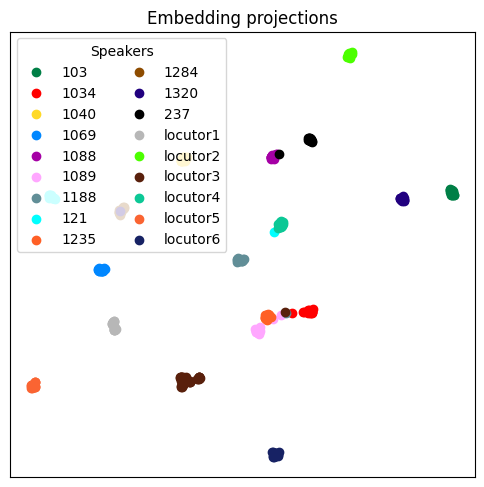





demo/synthesized_audios/YourTTS


Preprocessing wavs: 100%|██████████| 377/377 [00:05<00:00, 71.91it/s]


Loaded the voice encoder model on cpu in 0.01 seconds.
['1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', 

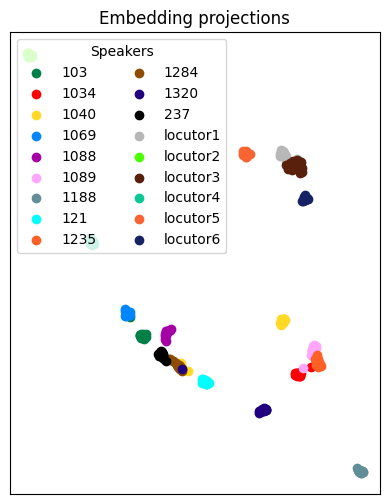





demo/synthesized_audios/XTTS


Preprocessing wavs: 100%|██████████| 377/377 [00:06<00:00, 58.48it/s]


Loaded the voice encoder model on cpu in 0.01 seconds.
['1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', 'locutor2', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', 

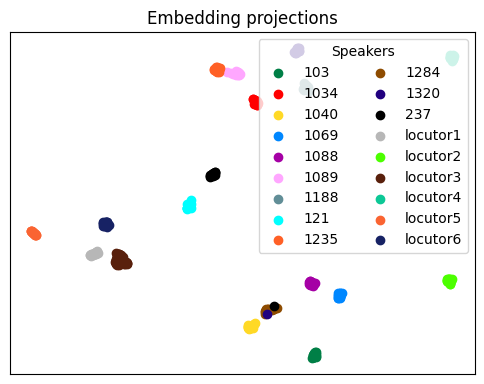





demo/synthesized_audios/TorToise


Preprocessing wavs: 100%|██████████| 240/240 [00:06<00:00, 39.59it/s]


Loaded the voice encoder model on cpu in 0.01 seconds.
['1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1320', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '1034', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '237', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '1188', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', '103', '1069', '1069', '1069', '1069', '1069', '1069', '1069', '1069', '1069', '1069', '1069', '1069', '1069', '1069', '1069', '1069', '1069', '1069', '1069', '1069', '1040', '1040', '1040', 

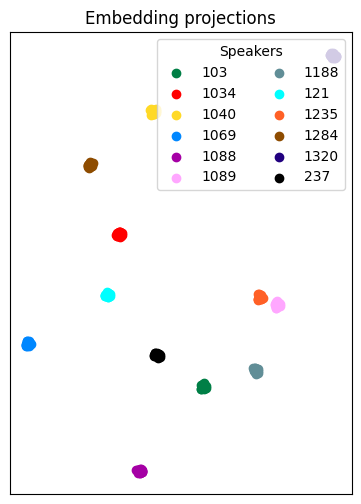

In [ ]:
# original_directories = ['audio', 'synthesized_audios/YourTTS', 'synthesized_audios/XTTS',
#                         'synthesized_audios/TorToise']


# for original_directory in original_directories:
#   # new_directory = '/'.join(original_directory.split('/')[1:]) + '_demo'
#   new_directory = os.path.join('demo', original_directory)
#   prepare_audios_demo3(original_directory, new_directory, min_duration=0)
#   print('\n\n\n')
#   print(new_directory)
#   demo3(new_directory)

# shutil.rmtree('demo')





demo/audio


Preprocessing wavs: 100%|██████████| 377/377 [00:13<00:00, 27.10it/s]


Loaded the voice encoder model on cpu in 0.03 seconds.


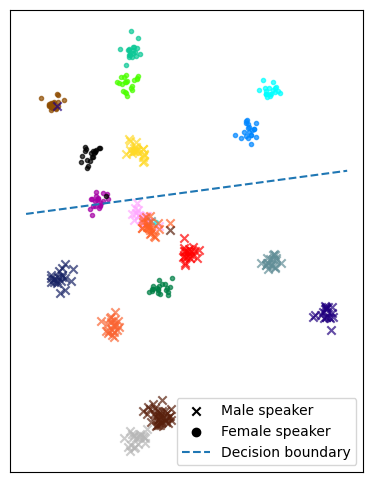





demo/synthesized_audios/YourTTS


Preprocessing wavs: 100%|██████████| 377/377 [00:06<00:00, 55.49it/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


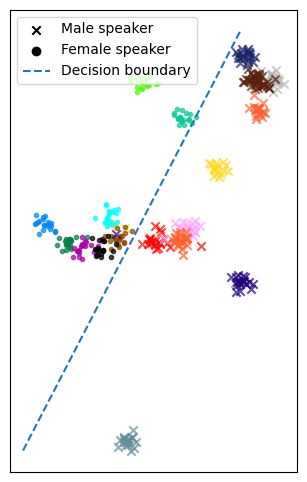





demo/synthesized_audios/XTTS


Preprocessing wavs: 100%|██████████| 377/377 [00:06<00:00, 59.12it/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


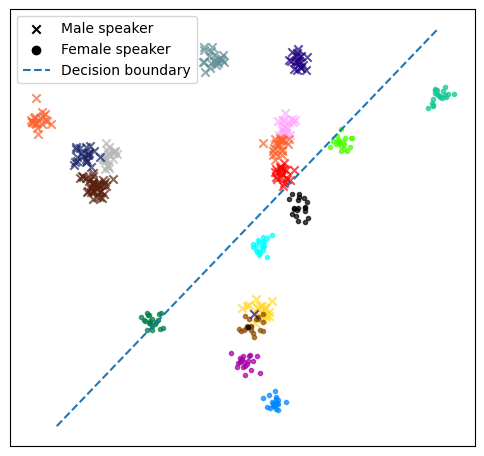





demo/synthesized_audios/TorToise


Preprocessing wavs: 100%|██████████| 240/240 [00:03<00:00, 75.05it/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


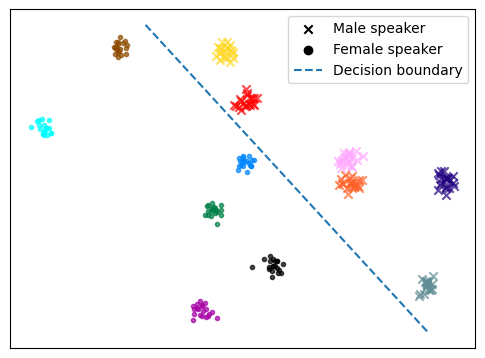

In [ ]:
original_directories = ['audio', 'synthesized_audios/YourTTS', 'synthesized_audios/XTTS',
                        'synthesized_audios/TorToise']
sexes_dict = {
              # Spanish
              'locutor1': 'M',
              'locutor2': 'F',
              'locutor3': 'M',
              'locutor4': 'F',
              'locutor5': 'M',
              'locutor6': 'M',
              # train
              '103': 'F',
              '1034': 'M',
              '1040': 'M',
              '1069': 'F',
              '1235': 'M',
              '1088': 'F',
              # test
              '1089': 'M',
              '1188': 'M',
              '121': 'F',
              '237': 'F',
              '1284': 'F',
              '1320': 'M',
              }

for original_directory in original_directories:
  # new_directory = '/'.join(original_directory.split('/')[1:]) + '_demo'
  new_directory = os.path.join('demo', original_directory)
  prepare_audios_demo3(original_directory, new_directory, min_duration=0)
  print('\n\n\n')
  print(new_directory)
  demo3(new_directory, sexes_dict)

shutil.rmtree('demo')

# Demo 4: speaker sex clustering

## Prepare the data as necessary

In [ ]:
# import os
# import shutil

# def prepare_data_demo4(source_directory, destination_directory):

#   # Iterate through dataset folders
#   for dataset_folder in os.listdir(source_directory):
#       dataset_path = os.path.join(source_directory, dataset_folder)

#       # Check if it's a directory
#       if os.path.isdir(dataset_path):
#           # Iterate through sentence files in each dataset
#           for sentence_file in os.listdir(dataset_path):
#               sentence_path = os.path.join(dataset_path, sentence_file)

#               # Check if it's a file
#               if os.path.isfile(sentence_path):
#                   # Extract speaker and sentence information
#                   speaker = sentence_file.split('_')[0]
#                   sentence = sentence_file

#                   # Create the destination folder
#                   destination_folder = os.path.join(destination_directory, speaker)
#                   os.makedirs(destination_folder, exist_ok=True)

#                   # Copy the file to the destination
#                   destination_path = os.path.join(destination_folder, sentence_file)
#                   shutil.copy(sentence_path, destination_path)

#   # Keep one audio of each speaker
#   for speaker_id in os.listdir(destination_directory):

#     # Get a list of all files in the directory
#     files = os.listdir(os.path.join(destination_directory, speaker_id))

#     # Sort the files to ensure the first one is not deleted
#     files.sort()

#     # Iterate through the files starting from the second one
#     for file_name in files[1:]:
#         file_path = os.path.join(destination_directory, speaker_id, file_name)

#         # Check if it's a file before deleting
#         if os.path.isfile(file_path):
#             os.remove(file_path)

#     # Rename the remaining audio only with the name of the speaker
#     os.rename(os.path.join(destination_directory, speaker_id, files[0]), os.path.join(destination_directory, speaker_id, speaker_id + '.wav'))


## Run demo

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from resemblyzer import preprocess_wav, VoiceEncoder
# # from demo_utils import *
# from pathlib import Path
# from tqdm import tqdm
# import numpy as np

# def demo4(audios_path, sexes_dict):
#   # DEMO 04: building from the previous demonstration, we'll show how natural properties of the
#   # voice can emerge through analysis of the embeddings. The dimensionality reduction algorithm
#   # UMAP will create clusters from embeddings with similar features. When provided with samples
#   # from many distinct speakers, it tends to create two clusters for each sex. This is what we'll
#   # show here, by using the speaker metadata file provided in the LibriSpeech dataset to retrieve
#   # the sex of each speaker. Note that this information was never used during training of the voice
#   # encoder model, be it as input feature or target. This means that the distinction was learned
#   # entirely in an unsupervised manner.
#   # Note that if you try this code on different data (or on fewer speakers), you may observe an
#   # entirely different clustering, e.g. based on the accent of the speakers. Changing the
#   # parameters of UMAP or the dimensionality reduction altogether will also give you a different
#   # view of the manifold.


#   ## Gather a single utterance per speaker
#   data_dir = Path(audios_path)
#   wav_fpaths = list(data_dir.glob("**/*.wav"))
#   # wav_fpaths = list(data_dir.glob("*.wav"))
#   speakers = [fpath.stem.split("-")[0] for fpath in wav_fpaths]
#   wavs = [preprocess_wav(wav_fpath) for wav_fpath in \
#           tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), unit=" utterances")]

#   # Get the sex of each speaker
#   markers = ["x" if sexes_dict[speaker] == "M" else "o" for speaker in speakers]
#   colors = ["black"] * len(speakers)


#   ## Compute the embeddings
#   encoder = VoiceEncoder()
#   utterance_embeds = np.array(list(map(encoder.embed_utterance, wavs)))


#   ## Project the embeddings in 2D space.
#   _, ax = plt.subplots(figsize=(6, 6))
#   # Passing min_dist=1 to UMAP will make it so the projections don't necessarily need to fit in
#   # clusters, so that you can have a better idea of what the manifold really looks like.
#   projs = plot_projections(utterance_embeds, speakers, ax, colors, markers, False,
#                           min_dist=1)
#   ax.set_title("Embeddings for %d speakers" % (len(speakers)))
#   ax.scatter([], [], marker="x", c="black", label="Male speaker")
#   ax.scatter([], [], marker="o", c="black", label="Female speaker")

#   # Separate the data by the sex
#   classifier = LogisticRegression(solver="lbfgs")
#   classifier.fit(projs, markers)
#   x = np.linspace(*ax.get_xlim(), num=200)
#   y = -(classifier.coef_[0, 0] * x + classifier.intercept_) / classifier.coef_[0, 1]
#   mask = (y > ax.get_ylim()[0]) & (y < ax.get_ylim()[1])
#   ax.plot(x[mask], y[mask], label="Decision boundary")

#   ax.legend()
#   plt.show()





demo/audio


Preprocessing wavs: 100%|██████████| 18/18 [00:00<00:00, 64.53 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.
[[ 4.8960967  -1.2694784 ]
 [ 7.927997   -2.2652464 ]
 [ 2.933006   -1.6008216 ]
 [ 7.785591   -0.14609589]
 [ 6.8087215  -1.9239978 ]
 [ 6.4300876   0.6783371 ]
 [ 5.4006243  -3.5137093 ]
 [ 6.763469   -0.72711414]
 [ 3.5084138  -0.5280111 ]
 [ 4.7191763   0.565609  ]
 [ 4.1849227  -3.6031578 ]
 [ 4.1519866  -2.2783883 ]
 [ 8.367063   -1.3351601 ]
 [ 5.5151434  -0.48894486]
 [ 6.728573   -3.4855928 ]
 [ 7.814103   -3.4573767 ]
 [ 2.9478173  -3.1004004 ]
 [ 5.8029313  -2.1013587 ]]


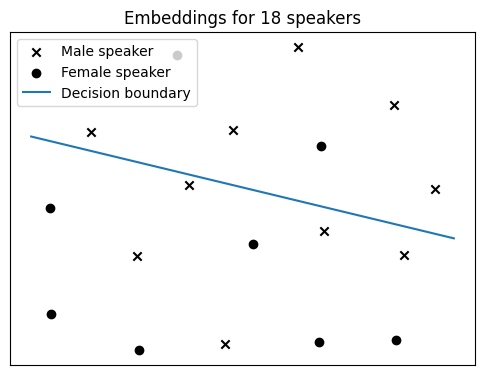





demo/synthesized_audios/YourTTS


Preprocessing wavs: 100%|██████████| 18/18 [00:00<00:00, 70.29 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.
[[-10.071917   13.664962 ]
 [-12.953947   11.64395  ]
 [-11.762935   14.493454 ]
 [ -9.64973    15.364699 ]
 [-11.405975   12.715673 ]
 [-10.079645   16.563692 ]
 [-13.38216    14.627578 ]
 [-10.613256   14.78685  ]
 [-12.52244    15.799196 ]
 [-14.4801235  12.548792 ]
 [-13.359968   12.989656 ]
 [-14.503913   14.046283 ]
 [-11.050456   15.686739 ]
 [ -8.589722   14.856607 ]
 [ -8.847883   13.3780985]
 [-11.848817   11.453543 ]
 [-12.607483   13.626458 ]
 [-10.463963   11.836362 ]]


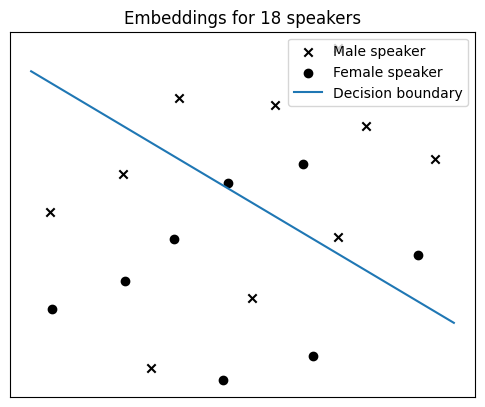





demo/synthesized_audios/XTTS


Preprocessing wavs: 100%|██████████| 18/18 [00:00<00:00, 74.93 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.
[[  1.8984245  -15.3959465 ]
 [  3.2164717  -13.304333  ]
 [ -0.49914917 -16.351906  ]
 [  4.8069463  -13.378225  ]
 [  2.9223158  -14.339057  ]
 [  4.116918   -14.380929  ]
 [  0.7949279  -12.822662  ]
 [  3.62772    -15.851003  ]
 [  0.5749956  -15.8160715 ]
 [  1.5560695  -14.327303  ]
 [ -0.38721213 -13.4603405 ]
 [  0.23524077 -14.496354  ]
 [  4.8380733  -15.456264  ]
 [  2.7352574  -16.651884  ]
 [  1.171857   -16.90448   ]
 [  1.9270263  -12.7359915 ]
 [ -0.98562    -14.849556  ]
 [  3.4092119  -12.036234  ]]


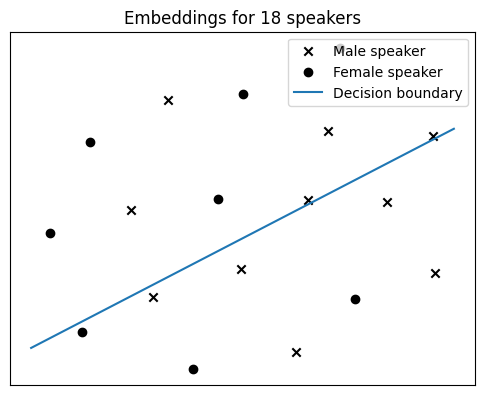





demo/synthesized_audios/TorToise


Preprocessing wavs: 100%|██████████| 12/12 [00:00<00:00, 72.47 utterances/s]

Loaded the voice encoder model on cpu in 0.01 seconds.



/usr/local/lib/python3.10/dist-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


[[ 8.791158    0.74308974]
 [10.442774   -0.3801973 ]
 [10.817124   -1.6493703 ]
 [10.249982    0.9676947 ]
 [ 9.563583   -2.4411237 ]
 [10.174907   -3.7944655 ]
 [ 8.107238   -2.1778233 ]
 [11.272733   -3.1871107 ]
 [ 8.572321   -3.8034387 ]
 [12.254583   -1.8857167 ]
 [11.732787    0.13255003]
 [ 9.125735   -0.7791635 ]]


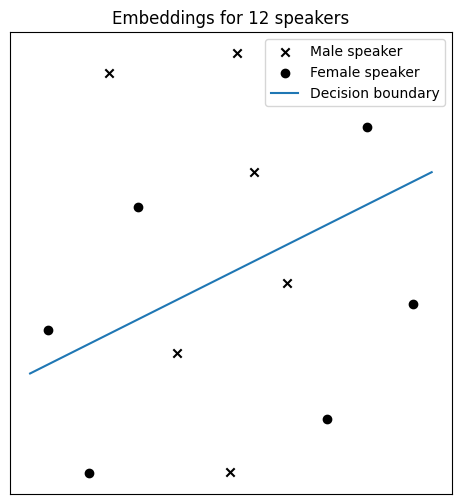

In [ ]:
# # 'M': male
# # 'F': female

# sexes_dict = {
#               # Spanish
#               'locutor1': 'M',
#               'locutor2': 'F',
#               'locutor3': 'M',
#               'locutor4': 'F',
#               'locutor5': 'M',
#               'locutor6': 'M',
#               # train
#               '103': 'F',
#               '1034': 'M',
#               '1040': 'M',
#               '1069': 'F',
#               '1235': 'M',
#               '1088': 'F',
#               # test
#               '1089': 'M',
#               '1188': 'M',
#               '121': 'F',
#               '237': 'F',
#               '1284': 'F',
#               '1320': 'M',
#               }

# original_directories = ['audio', 'synthesized_audios/YourTTS', 'synthesized_audios/XTTS', 'synthesized_audios/TorToise']

# for original_directory in original_directories:
#   new_directory = os.path.join('demo', original_directory)
#   prepare_data_demo4(original_directory, new_directory)
#   print('\n\n\n')
#   print(new_directory)
#   demo4(new_directory, sexes_dict)

# shutil.rmtree('demo')

# Demo 5: fake speech detection

In [ ]:
from resemblyzer import preprocess_wav, VoiceEncoder
# from demo_utils import *
from pathlib import Path
from tqdm import tqdm
import numpy as np

def demo5(audios_path, model, dataset, fake_df):

  # DEMO 05: In this demo we'll show how we can achieve a modest form of fake speech detection.
  # This method assumes you have some reference audio for the target speaker that you
  # know is real, so it is not a universal fake speech detector on its own.
  # In each audio data directory we have segments. Some are real and extracted from
  # actual speeches, while the remaining others are fake and generated by various models
  # with a high discrepancy of voice cloning quality and naturalness achieved. We will
  # take 6 segments of real speech as ground truth reference and compare those against the
  # remaining. Those segments are selected at random, so will run into different results every time
  # you run the script, but they should be more or less consistent.


  ## Load and preprocess the audio
  data_dir = Path(audios_path)
  wav_fpaths = list(data_dir.glob("**/*.wav"))
  wavs = [preprocess_wav(wav_fpath) for wav_fpath in \
          tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), unit=" utterances")]


  ## Compute the embeddings
  encoder = VoiceEncoder()
  embeds = np.array([encoder.embed_utterance(wav) for wav in wavs])
  speakers = np.array([fpath.parent.name for fpath in wav_fpaths])
  names = np.array([fpath.stem for fpath in wav_fpaths])


  # Take 6 real embeddings at random, and leave the others for testing
  gt_indices = np.random.choice(*np.where(speakers == "real"), 6, replace=False)
  mask = np.zeros(len(embeds), dtype=bool)
  mask[gt_indices] = True
  gt_embeds = embeds[mask]
  gt_names = names[mask]
  gt_speakers = speakers[mask]
  embeds, speakers, names = embeds[~mask], speakers[~mask], names[~mask]


  ## Compare all embeddings against the ground truth embeddings, and compute the average similarities.
  scores = (gt_embeds @ embeds.T).mean(axis=0)

  # Order the scores by decreasing order
  sort = np.argsort(scores)[::-1]
  scores, names, speakers = scores[sort], names[sort], speakers[sort]

  threshold = np.mean(scores)

  ## Plot the scores
  fig, _ = plt.subplots(figsize=(6, 6))
  indices = np.arange(len(scores))
  plt.axhline(threshold, ls="dashed", label="Prediction threshold", c="black")
  plt.bar(indices[speakers == "real"], scores[speakers == "real"], color="green", label="Real")
  plt.bar(indices[speakers == "fake"], scores[speakers == "fake"], color="red", label="Fake")
  plt.legend()
  plt.xticks(indices, names, rotation="vertical", fontsize=8)
  plt.xticks([])
  # plt.xlabel("Audio IDs")
  plt.ylim(min(scores) - 0.02, max(scores) + 0.02)
  plt.ylabel("Similarity to ground truth")
  fig.subplots_adjust(bottom=0.25)
  plt.show()

  # print(scores, names, speakers, indices)

  predictions = ["real" if score > threshold else "fake" for score in scores]

  new_rows = pd.DataFrame({'Audio ID': names,
                           'Model': model,
                           'Dataset': dataset,
                           'True label': speakers,
                           'Predicted label': predictions})

  fake_df = pd.concat([fake_df, new_rows], ignore_index=True)

  return fake_df

In [ ]:
def prepare_data_demo5(model, dataset, speaker_id):
  # dataset: Spanish, train, test.
  # model: YourTTS, XTTS, TorToise.
  # speaker_id: locutor1, 103, ...

  os.makedirs('demo5/real')
  os.makedirs('demo5/fake')

  real_audios_path = os.path.join('audio', dataset)
  i = 0
  for audio in os.listdir(real_audios_path):

    if speaker_id + '_' in audio:
      shutil.copy(os.path.join(real_audios_path, audio), os.path.join('demo5/real', 'audio_' + str(i) + '.wav'))
      i = i + 1

  fake_audios_path = os.path.join('synthesized_audios', model, dataset)
  i = 0
  for fake_audio in os.listdir(fake_audios_path):

    if speaker_id + '_' in fake_audio:
      shutil.copy(os.path.join(fake_audios_path, fake_audio), os.path.join('demo5/fake', 'audio_' + str(i) + '_' + model + '.wav'))
      i = i + 1

In [ ]:
# shutil.rmtree('demo5')





TorToise train 103


Preprocessing wavs: 100%|██████████| 40/40 [00:11<00:00,  3.63 utterances/s]


Loaded the voice encoder model on cpu in 0.06 seconds.


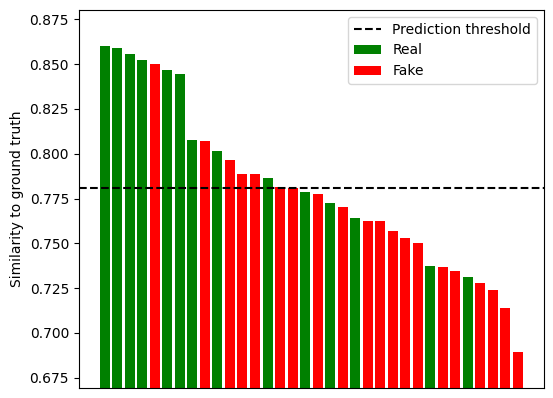





TorToise train 1034


Preprocessing wavs: 100%|██████████| 40/40 [00:01<00:00, 26.24 utterances/s]


Loaded the voice encoder model on cpu in 0.07 seconds.


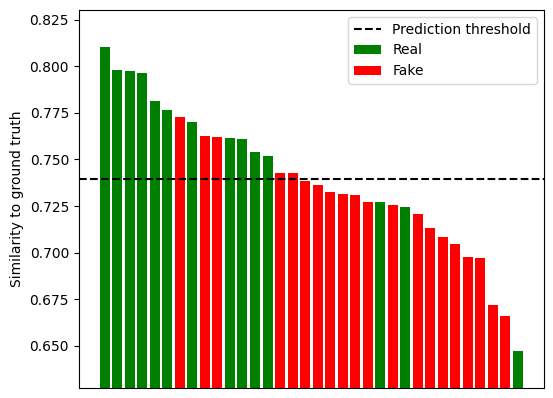





TorToise train 1040


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 48.58 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


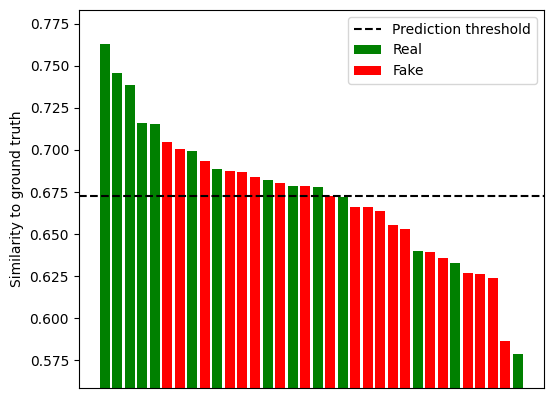





TorToise train 1069


Preprocessing wavs: 100%|██████████| 40/40 [00:01<00:00, 33.12 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


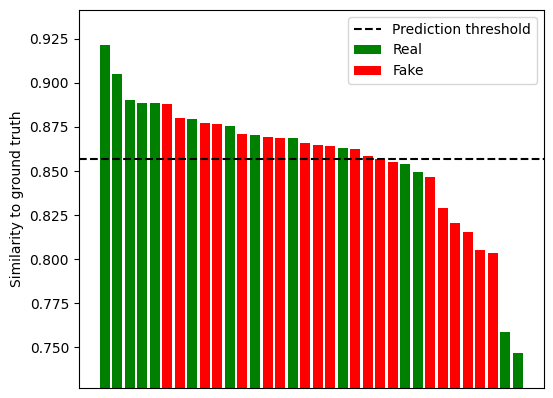





TorToise train 1235


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 49.93 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


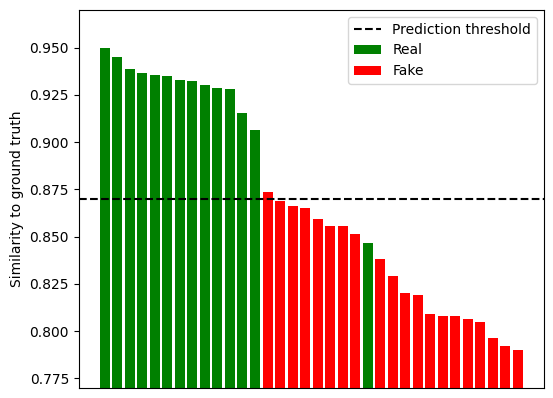





TorToise train 1088


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 79.58 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


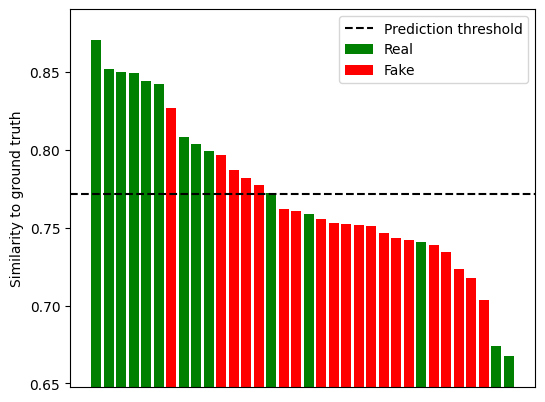





TorToise test 1089


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 63.29 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


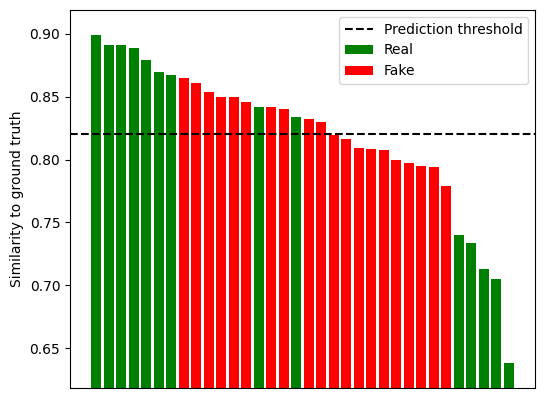





TorToise test 1188


Preprocessing wavs: 100%|██████████| 40/40 [00:01<00:00, 30.70 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


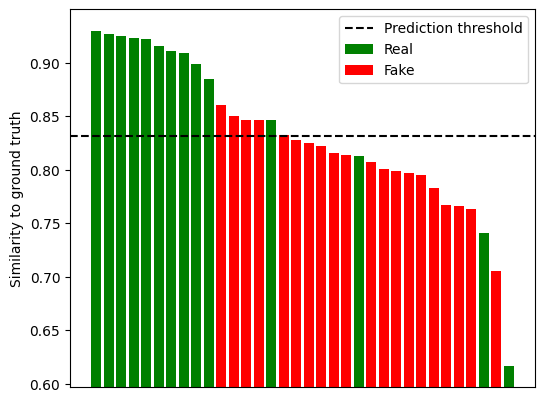





TorToise test 121


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 60.36 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


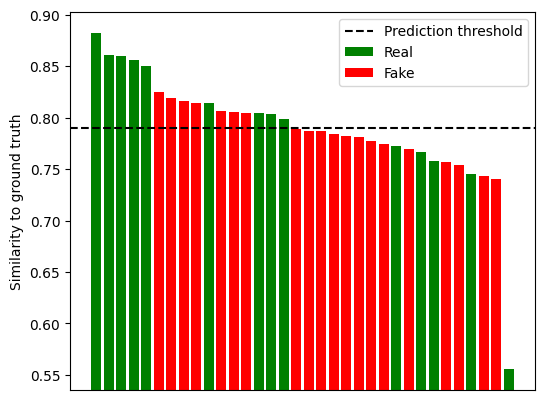





TorToise test 237


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 76.66 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


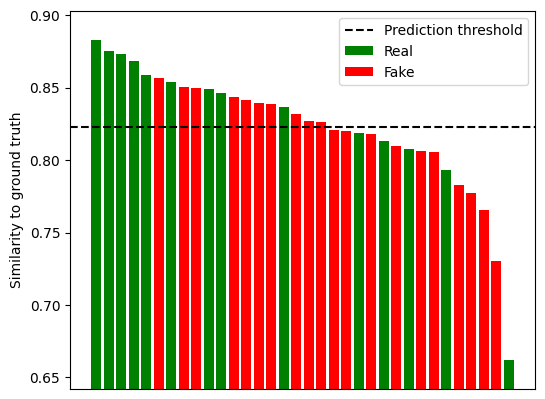





TorToise test 1284


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 71.22 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


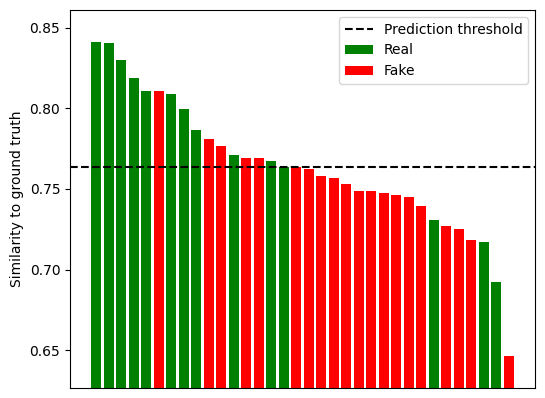





TorToise test 1320


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 61.13 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


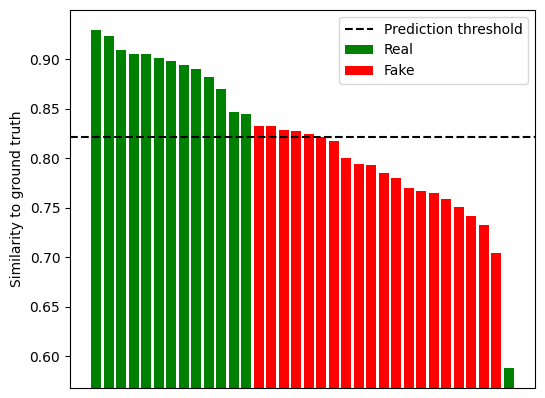





TorToise Spanish locutor1




TorToise Spanish locutor2




TorToise Spanish locutor3




TorToise Spanish locutor4




TorToise Spanish locutor5




TorToise Spanish locutor6




XTTS train 103


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 55.39 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.


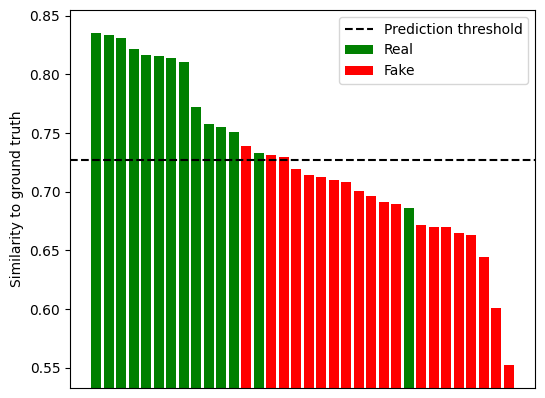





XTTS train 1034


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 84.09 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


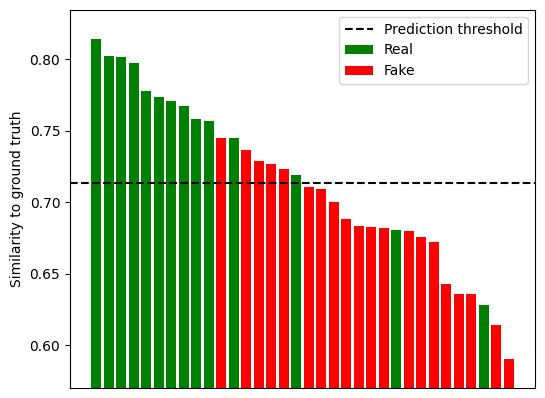





XTTS train 1040


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 69.86 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


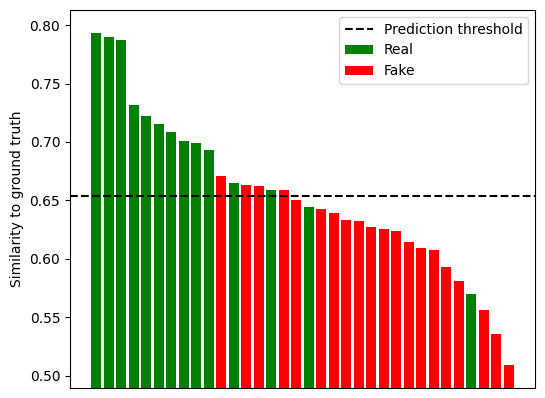





XTTS train 1069


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 44.09 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


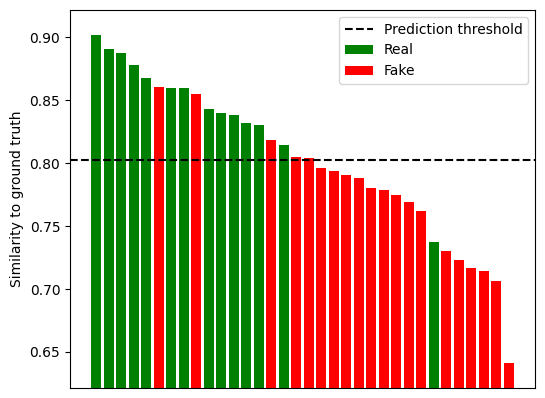





XTTS train 1235


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 49.39 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


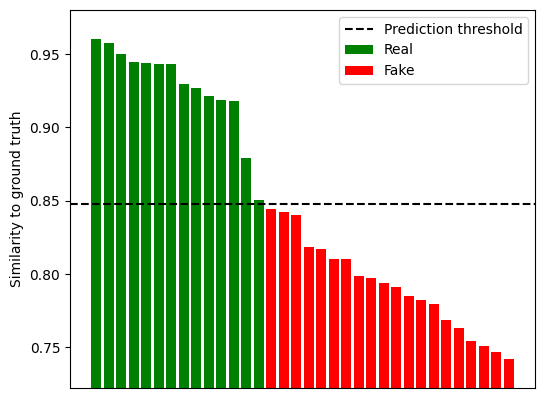





XTTS train 1088


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 51.22 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


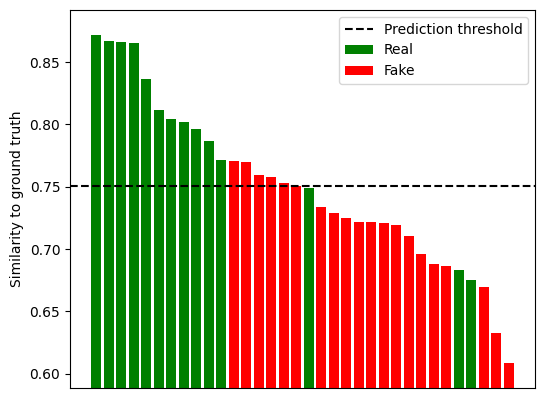





XTTS test 1089


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 62.06 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


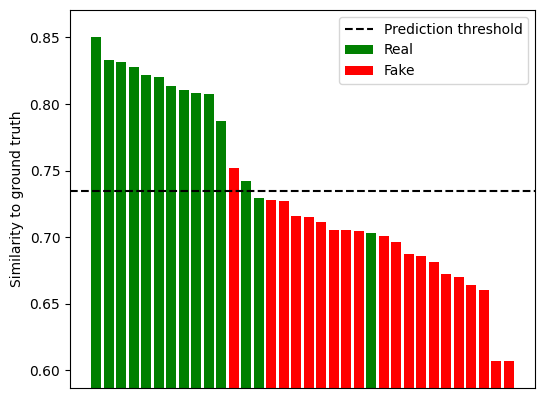





XTTS test 1188


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 54.60 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


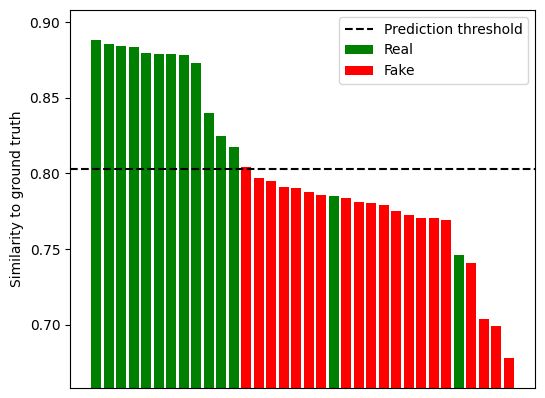





XTTS test 121


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 66.82 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


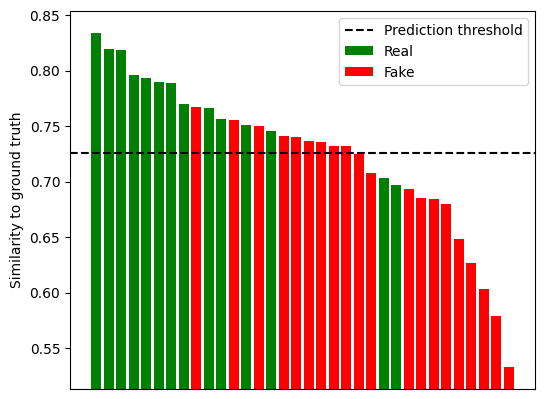





XTTS test 237


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 86.35 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


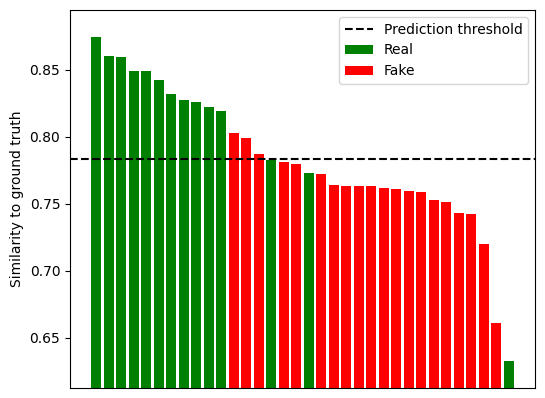





XTTS test 1284


Preprocessing wavs: 100%|██████████| 40/40 [00:01<00:00, 20.55 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


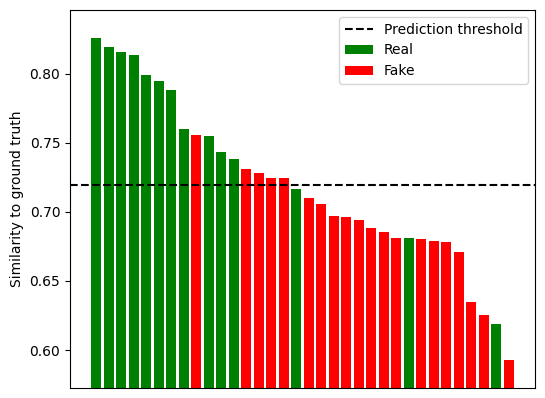





XTTS test 1320


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 64.16 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


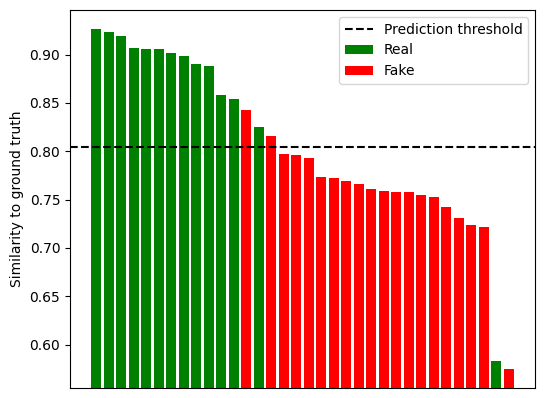





XTTS Spanish locutor1


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 61.35 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


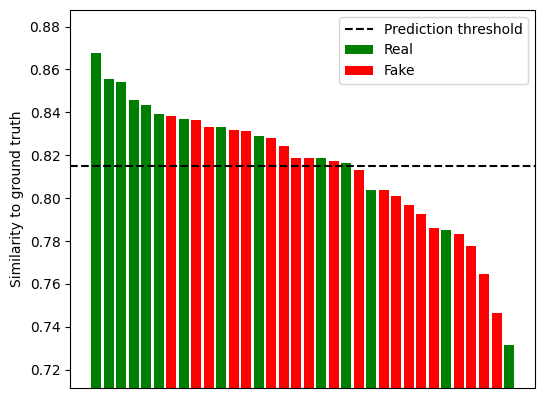





XTTS Spanish locutor2


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 59.45 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


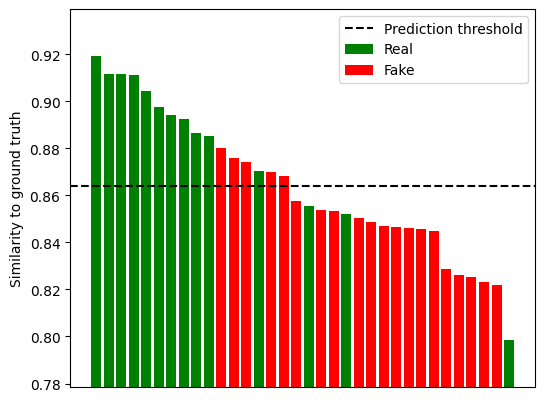





XTTS Spanish locutor3


Preprocessing wavs: 100%|██████████| 74/74 [00:01<00:00, 42.40 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


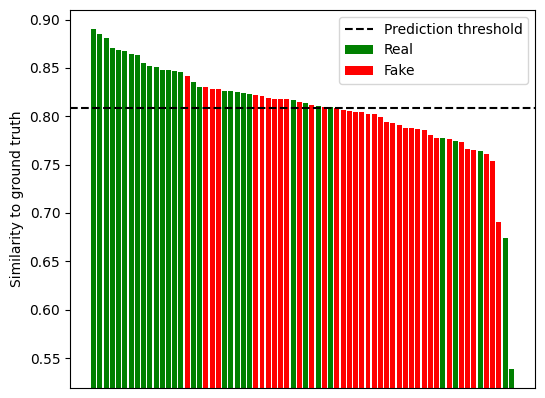





XTTS Spanish locutor4


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 59.18 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


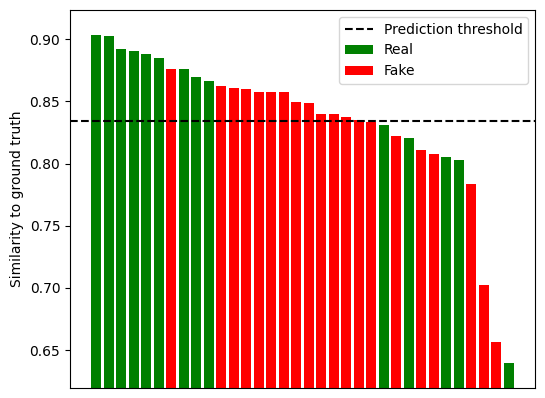





XTTS Spanish locutor5


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 53.70 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


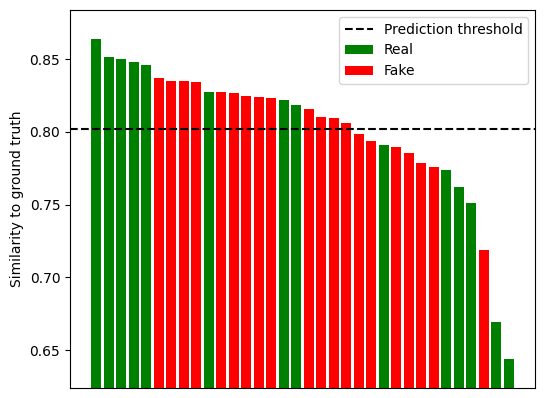





XTTS Spanish locutor6


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 53.01 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


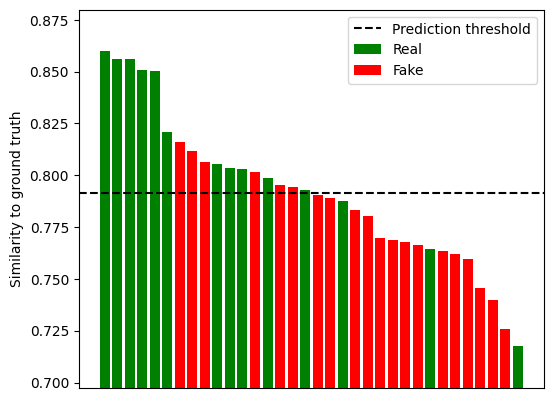





YourTTS train 103


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 106.58 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


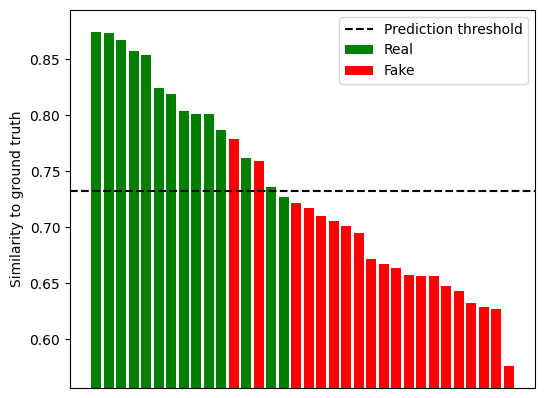





YourTTS train 1034


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 81.00 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


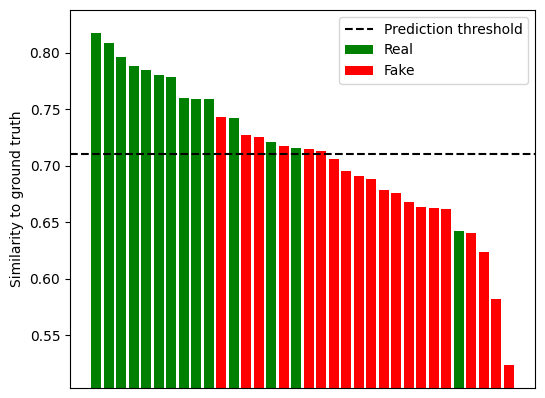





YourTTS train 1040


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 93.07 utterances/s] 


Loaded the voice encoder model on cpu in 0.01 seconds.


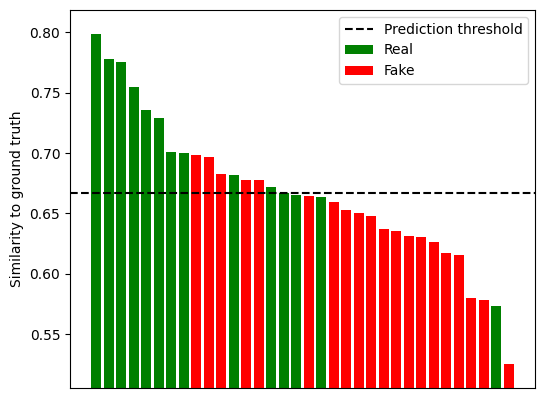





YourTTS train 1069


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 49.84 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


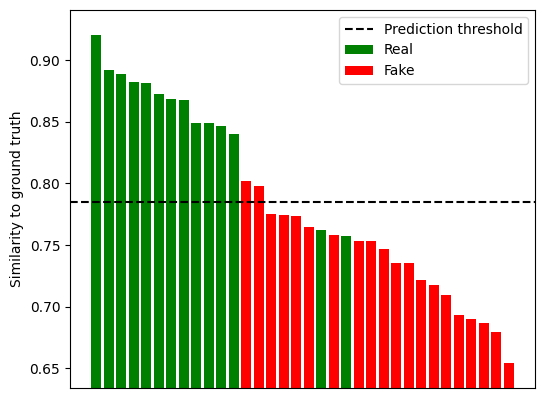





YourTTS train 1235


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 44.51 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


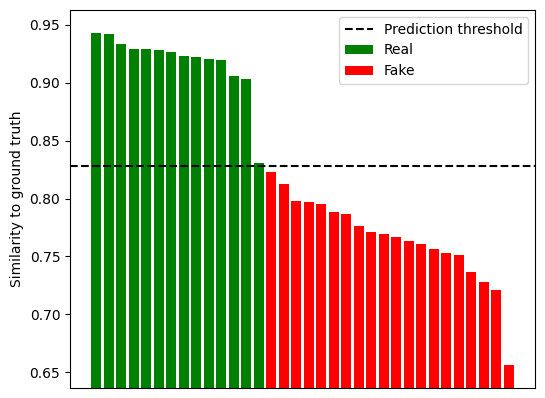





YourTTS train 1088


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 58.22 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


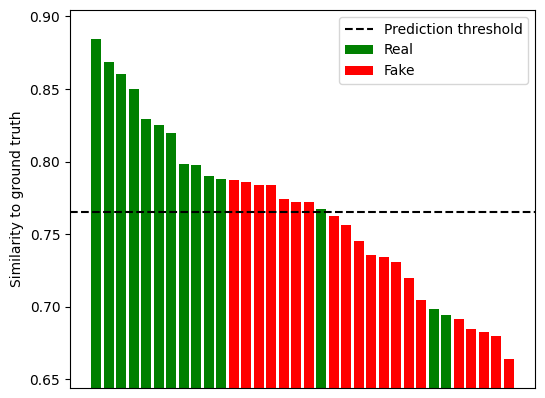





YourTTS test 1089


Preprocessing wavs: 100%|██████████| 40/40 [00:01<00:00, 39.81 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


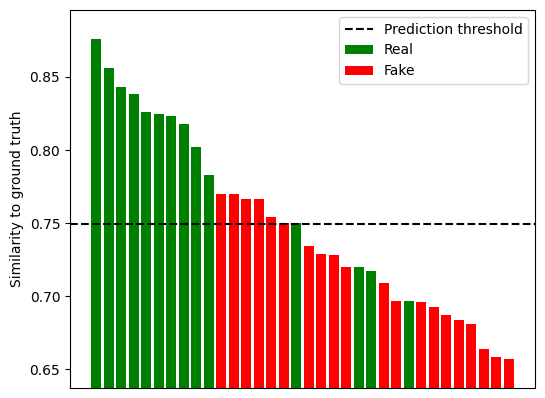





YourTTS test 1188


Preprocessing wavs: 100%|██████████| 40/40 [00:01<00:00, 35.19 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


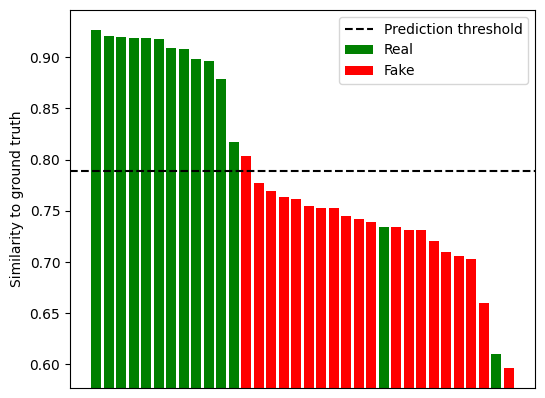





YourTTS test 121


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 65.54 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


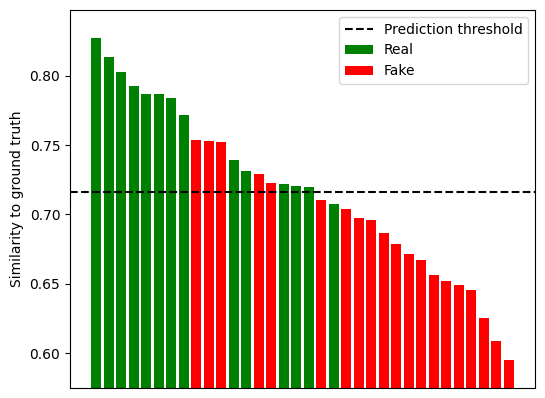





YourTTS test 237


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 80.69 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


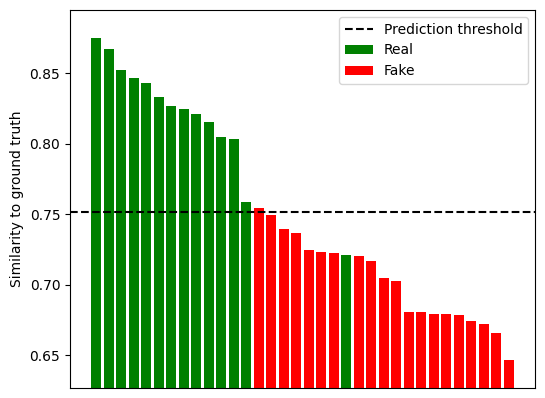





YourTTS test 1284


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 83.21 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


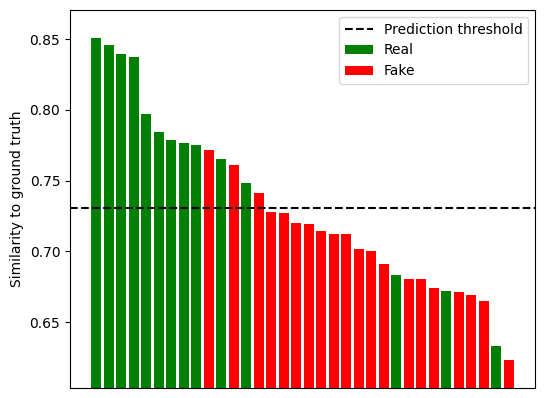





YourTTS test 1320


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 61.18 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


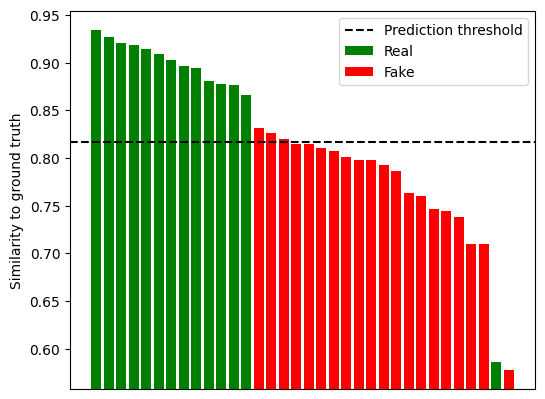





YourTTS Spanish locutor1


Preprocessing wavs: 100%|██████████| 40/40 [00:01<00:00, 39.94 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


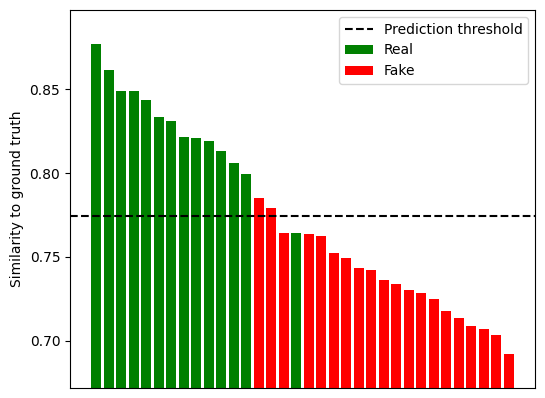





YourTTS Spanish locutor2


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 56.24 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


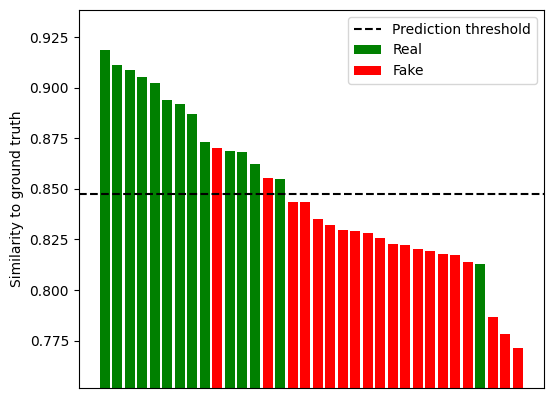





YourTTS Spanish locutor3


Preprocessing wavs: 100%|██████████| 74/74 [00:02<00:00, 27.31 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


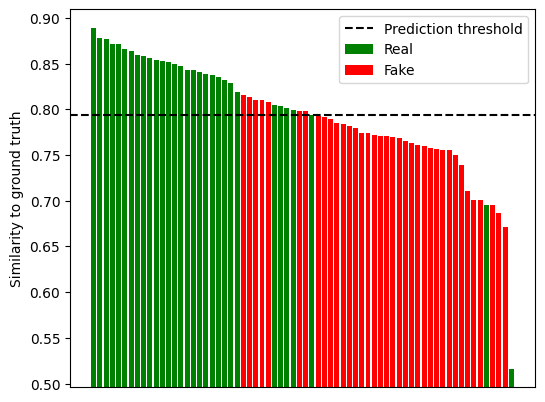





YourTTS Spanish locutor4


Preprocessing wavs: 100%|██████████| 40/40 [00:01<00:00, 38.16 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


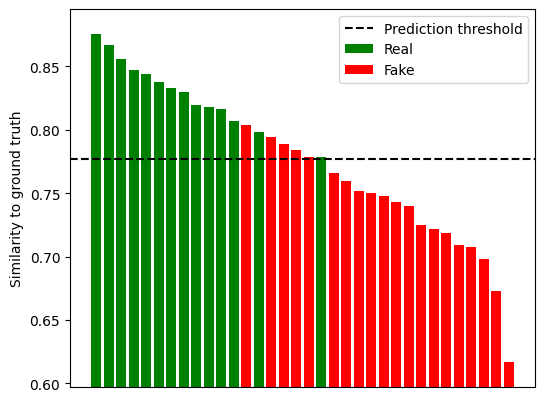





YourTTS Spanish locutor5


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 55.41 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


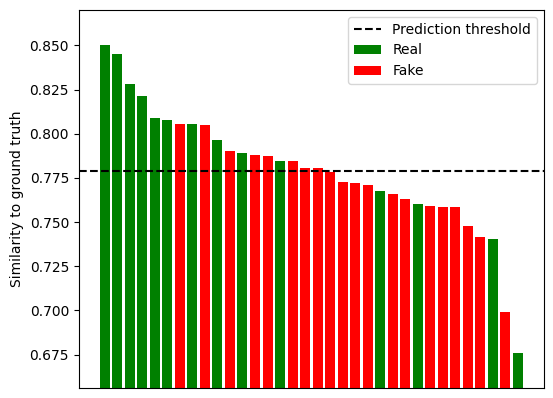





YourTTS Spanish locutor6


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 53.63 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


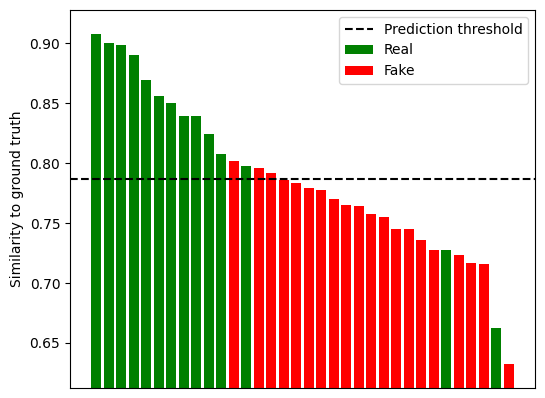

In [ ]:
import os
import shutil
models = ['TorToise', 'XTTS', 'YourTTS']

datasets = ['train', 'test' , 'Spanish']

speaker_ids = {'train': ['103', '1034', '1040', '1069', '1235', '1088'],
               'test': ['1089', '1188', '121', '237', '1284', '1320'],
               'Spanish': ['locutor1', 'locutor2', 'locutor3', 'locutor4', 'locutor5', 'locutor6']
               }
# models = ['TorToise']
# datasets = ['train']
# speaker_ids = {'train': ['103']}
fake_df = pd.DataFrame(columns=['Audio ID', 'Model', 'Dataset', 'True label', 'Predicted label'])

for model in models:
  for dataset in datasets:
    for speaker_id in speaker_ids[dataset]:
      try:
        print('\n\n\n')
        print(model, dataset, speaker_id)
        prepare_data_demo5(model, dataset, speaker_id)
        fake_df = demo5('demo5', model, dataset, fake_df)
        shutil.rmtree('demo5')
      except:
        shutil.rmtree('demo5')

In [ ]:
fake_df

,Audio ID,Model,Dataset,True label,Predicted label
0,audio_18,TorToise,train,real,real
1,audio_13,TorToise,train,real,real
2,audio_14,TorToise,train,real,real
3,audio_11,TorToise,train,real,real
4,audio_3_TorToise,TorToise,train,fake,real
...,...,...,...,...,...
1695,audio_0_YourTTS,YourTTS,Spanish,fake,fake
1696,audio_7_YourTTS,YourTTS,Spanish,fake,fake
1697,audio_15_YourTTS,YourTTS,Spanish,fake,fake
1698,audio_2,YourTTS,Spanish,real,fake


In [ ]:
fake_df['y_true'] = fake_df['True label'].apply(lambda x: 0 if x == 'real' else 1)
fake_df['y_pred'] = fake_df['Predicted label'].apply(lambda x: 0 if x == 'real' else 1)

fake_df

,Audio ID,Model,Dataset,True label,Predicted label,y_true,y_pred
0,audio_18,TorToise,train,real,real,0,0
1,audio_13,TorToise,train,real,real,0,0
2,audio_14,TorToise,train,real,real,0,0
3,audio_11,TorToise,train,real,real,0,0
4,audio_3_TorToise,TorToise,train,fake,real,1,0
...,...,...,...,...,...,...,...
1695,audio_0_YourTTS,YourTTS,Spanish,fake,fake,1,1
1696,audio_7_YourTTS,YourTTS,Spanish,fake,fake,1,1
1697,audio_15_YourTTS,YourTTS,Spanish,fake,fake,1,1
1698,audio_2,YourTTS,Spanish,real,fake,0,1


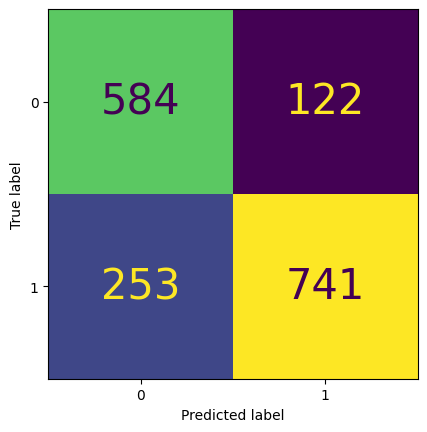

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(fake_df['y_true'], fake_df['y_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(colorbar=False, text_kw = {'fontsize': 30})
plt.show()

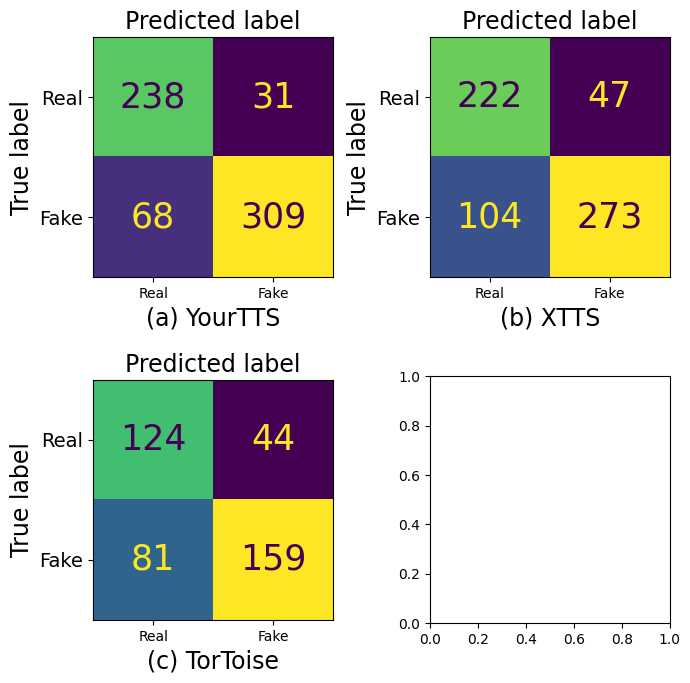

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

metrics_df = pd.DataFrame()
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
i, j = 0, 0

models = ['YourTTS', 'XTTS', 'TorToise']
for model in models:
    fake_df_filtered = fake_df[fake_df['Model'] == model]
    cm = confusion_matrix(fake_df_filtered['y_true'], fake_df_filtered['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[i, j], colorbar=False, text_kw = {'fontsize': 25})
    axs[i, j].set_title('Predicted label', fontsize=17)

    if model == 'YourTTS':
      subfigure = '(a) YourTTS'
    elif model == 'XTTS':
      subfigure = '(b) XTTS'
    else:
      subfigure = '(c) TorToise'

    axs[i, j].set_xlabel(subfigure, fontsize=17)
    axs[i, j].set_xticks(ticks=[0, 1], labels=['Real', 'Fake'])
    axs[i, j].set_ylabel('True label', fontsize=17)
    axs[i, j].set_yticks(ticks=[0, 1], labels=['Real', 'Fake'], fontsize=14)

    j += 1

    if j == 2:
      i = 1
      j = 0

    accuracy = accuracy_score(fake_df_filtered['y_true'], fake_df_filtered['y_pred'])
    precision = precision_score(fake_df_filtered['y_true'], fake_df_filtered['y_pred'])
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    new_row = pd.DataFrame({'Model': [model],
                            'Accuracy': [accuracy],
                            'Precisison': [precision],
                            'Sensitivity': [sensitivity],
                            'Specificity': [specificity]})

    metrics_df = pd.concat([new_row, metrics_df], ignore_index=True)

plt.tight_layout()
plt.show()

In [ ]:
metrics_df

,Model,Accuracy,Precisison,Sensitivity,Specificity
0,YourTTS,0.846749,0.908824,0.819629,0.884758
1,XTTS,0.766254,0.853125,0.724138,0.825279
2,TorToise,0.693627,0.783251,0.662500,0.738095


In [ ]:
##################################

In [ ]:
from resemblyzer import preprocess_wav, VoiceEncoder
# from demo_utils import *
from pathlib import Path
from tqdm import tqdm
import numpy as np

def demo5(audios_path, model, i, j, axs):

  # DEMO 05: In this demo we'll show how we can achieve a modest form of fake speech detection.
  # This method assumes you have some reference audio for the target speaker that you
  # know is real, so it is not a universal fake speech detector on its own.
  # In each audio data directory we have segments. Some are real and extracted from
  # actual speeches, while the remaining others are fake and generated by various models
  # with a high discrepancy of voice cloning quality and naturalness achieved. We will
  # take 6 segments of real speech as ground truth reference and compare those against the
  # remaining. Those segments are selected at random, so will run into different results every time
  # you run the script, but they should be more or less consistent.


  ## Load and preprocess the audio
  data_dir = Path(audios_path)
  wav_fpaths = list(data_dir.glob("**/*.wav"))
  wavs = [preprocess_wav(wav_fpath) for wav_fpath in \
          tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), unit=" utterances")]


  ## Compute the embeddings
  encoder = VoiceEncoder()
  embeds = np.array([encoder.embed_utterance(wav) for wav in wavs])
  speakers = np.array([fpath.parent.name for fpath in wav_fpaths])
  names = np.array([fpath.stem for fpath in wav_fpaths])


  # Take 6 real embeddings at random, and leave the others for testing
  gt_indices = np.random.choice(*np.where(speakers == "real"), 6, replace=False)
  mask = np.zeros(len(embeds), dtype=bool)
  mask[gt_indices] = True
  gt_embeds = embeds[mask]
  gt_names = names[mask]
  gt_speakers = speakers[mask]
  embeds, speakers, names = embeds[~mask], speakers[~mask], names[~mask]


  ## Compare all embeddings against the ground truth embeddings, and compute the average similarities.
  scores = (gt_embeds @ embeds.T).mean(axis=0)

  # Order the scores by decreasing order
  sort = np.argsort(scores)[::-1]
  scores, names, speakers = scores[sort], names[sort], speakers[sort]

  threshold = np.mean(scores)

  ## Plot the scores

  if model == 'YourTTS':
    subfigure = '(a)'
  elif model == 'XTTS':
    subfigure = '(b)'
  else:
    subfigure = '(c)'

  # fig, _ = plt.subplots(figsize=(6, 6))
  indices = np.arange(len(scores))
  axs[i, j].axhline(threshold, ls="dashed", label="Prediction threshold", c="black")
  axs[i, j].bar(indices[speakers == "real"], scores[speakers == "real"], color="green", label="Real")
  axs[i, j].bar(indices[speakers == "fake"], scores[speakers == "fake"], color="red", label="Fake")
  axs[i, j].legend()
  # axs[i, j].xticks(indices, names, rotation="vertical", fontsize=8)
  axs[i, j].set_xticks([])
  axs[i, j].set_yticks([0.6, 0.7, 0.8, 0.9])
  # axs[i, j].tick_params(axis='y', labelsize=20)
  # axs[i, j].xlabel("Audio IDs")
  axs[i, j].set_xlabel(subfigure + ' ' + model, fontsize=17)
  axs[i, j].set_ylim(min(scores) - 0.02, max(scores) + 0.02)
  axs[i, j].set_ylabel("Score", fontsize=17)
  # fig.subplots_adjust(bottom=0.25)
  # axs[i, j].show()

In [ ]:
# shutil.rmtree('demo5')





YourTTS test 1188


Preprocessing wavs: 100%|██████████| 40/40 [00:01<00:00, 29.95 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.




XTTS test 1188


Preprocessing wavs: 100%|██████████| 40/40 [00:01<00:00, 28.79 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.




TorToise test 1188


Preprocessing wavs: 100%|██████████| 40/40 [00:00<00:00, 43.11 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


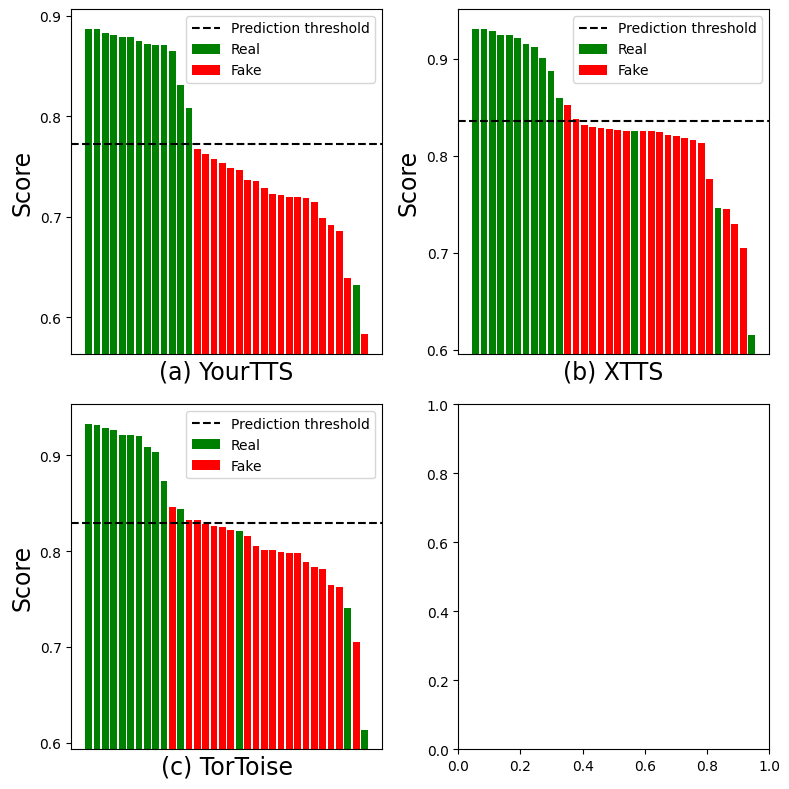

In [ ]:
models = ['YourTTS', 'XTTS', 'TorToise']
datasets = ['test']
speaker_ids = {'test': ['1188']}

i = 0
j = 0

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
for model in models:
  for dataset in datasets:
    for speaker_id in speaker_ids[dataset]:
        print('\n\n\n')
        print(model, dataset, speaker_id)
        prepare_data_demo5(model, dataset, speaker_id)
        demo5('demo5', model, i, j, axs)
        shutil.rmtree('demo5')
        j += 1
        if j == 2:
          j = 0
          i = 1

plt.tight_layout()
plt.show()